# Moving to Silicon Valley? Explore the Area by Data Science Methods

#### By Forough Mahmoudabadi
This notebook was used for IBM Applied Data Science Capstone Project.

#Part 1 - Clustering Cities in Santa Clara County

### Libraries

Here is the list of required libraries for our data analysis in Part1.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


A json file containing administrative boundaries for cities over which the County of Santa Clara, California holds authority ( Campbell, Cupertino, Gilroy, Los Altos, Los Altos Hills, Los Gatos, Milpitas, Monte Sereno, Morgan Hill, Mountain View, Palo Alto, San Jose, Santa Clara, Saratoga and Sunnyvale) is retrieved.

In [3]:
with open('Capstone Project/SantaClaraCounty.json') as json_santaclara:
    santaclara_data = json.load(json_santaclara)

Let's take a look at the file's keys.

In [4]:
print(santaclara_data.keys())
print(len(santaclara_data['features']))

dict_keys(['type', 'features', 'totalFeatures', 'numberMatched', 'numberReturned', 'timeStamp', 'crs', 'bbox'])
19


We can now retrieve the list of cities in Santa Clara County as below.

In [5]:
county_data = santaclara_data['features']
name_list=[]
for item in (county_data):
    name_list.append(item['properties']['name'])
print(len(name_list))
name_list

19


['MILPITAS',
 'SANTA CRUZ COUNTY',
 'GILROY',
 'MORGAN HILL',
 'MONTE SERENO',
 'SARATOGA',
 'CAMPBELL',
 'CUPERTINO',
 'MOUNTAIN VIEW',
 'SAN JOSE',
 'LOS ALTOS HILLS',
 'LOS ALTOS',
 'SANTA CLARA',
 'SUNNYVALE',
 'MOUNTAIN VIEW',
 'PALO ALTO',
 'LOS GATOS',
 'SAN JOSE',
 'SAN JOSE']

Note that some data are duplicates. We remove them. Then, we will have the list of citis in Santa Clara County.

In [6]:
name_list = ([name_list[0]] + list(name_list[2:-5]) + list(name_list[-4:-2]))
name_list

['MILPITAS',
 'GILROY',
 'MORGAN HILL',
 'MONTE SERENO',
 'SARATOGA',
 'CAMPBELL',
 'CUPERTINO',
 'MOUNTAIN VIEW',
 'SAN JOSE',
 'LOS ALTOS HILLS',
 'LOS ALTOS',
 'SANTA CLARA',
 'SUNNYVALE',
 'PALO ALTO',
 'LOS GATOS']

Next, we will use geopy to obtain the latitude and longitude values for each city. 

In [8]:
geolocator = Nominatim(user_agent="sc_explorer")
lat_list = []
lon_list = []
address_list = []

for i, item in enumerate(county_data):
    if item['properties']['name'] == 'SANTA CLARA':
        address_list.append('Santa Clara, CA 95050, USA')
    else:
        address_list.append(item['properties']['name'] + ', CA, USA')
    location = geolocator.geocode(address_list[i])
    lat_list.append(location.latitude)
    lon_list.append(location.longitude)
    print('Address:{}, Latitude:{}, Longitude:{}'.format(address_list[i], lat_list[i], lon_list[i]))

Address:MILPITAS, CA, USA, Latitude:37.4282724, Longitude:-121.9066238
Address:GILROY, CA, USA, Latitude:37.0065078, Longitude:-121.5631723
Address:MORGAN HILL, CA, USA, Latitude:37.130408, Longitude:-121.6544974
Address:MONTE SERENO, CA, USA, Latitude:37.236333, Longitude:-121.992458
Address:SARATOGA, CA, USA, Latitude:37.2638324, Longitude:-122.0230146
Address:CAMPBELL, CA, USA, Latitude:37.2870626, Longitude:-121.9448818
Address:CUPERTINO, CA, USA, Latitude:37.3228934, Longitude:-122.0322895
Address:MOUNTAIN VIEW, CA, USA, Latitude:37.3893889, Longitude:-122.0832101
Address:SAN JOSE, CA, USA, Latitude:37.3361905, Longitude:-121.8905833
Address:LOS ALTOS HILLS, CA, USA, Latitude:37.3796627, Longitude:-122.1374637
Address:LOS ALTOS, CA, USA, Latitude:37.3790629, Longitude:-122.116578
Address:Santa Clara, CA 95050, USA, Latitude:37.3541132, Longitude:-121.9551744
Address:SUNNYVALE, CA, USA, Latitude:37.3688301, Longitude:-122.0363496
Address:PALO ALTO, CA, USA, Latitude:37.4443293, Lon

We transform the data to a panda dataframe as below.

In [9]:
column_names = ['City', 'Latitude', 'Longitude'] 

# instantiate the dataframe
county_df = pd.DataFrame(columns=column_names)
county_df

,City,Latitude,Longitude


In [10]:
for i in range(0, 15):
    city = name_list[i]
    county_lat = lat_list[i]
    county_lon = lon_list[i]   
    county_df = county_df.append({'City': city, 'Latitude': county_lat,
                                          'Longitude': county_lon}, ignore_index=True)

Here is the list of cities in Santa Clara County along with their latitude and longitude values.

In [76]:
county_df

,City,Latitude,Longitude
0,MILPITAS,37.428272,-121.906624
1,GILROY,37.006508,-121.563172
2,MORGAN HILL,37.130408,-121.654497
3,MONTE SERENO,37.236333,-121.992458
4,SARATOGA,37.263832,-122.023015
5,CAMPBELL,37.287063,-121.944882
6,CUPERTINO,37.322893,-122.032290
7,MOUNTAIN VIEW,37.389389,-122.083210
8,SAN JOSE,37.336191,-121.890583
9,LOS ALTOS HILLS,37.379663,-122.137464


## Using Foursquare API for exploratory data analysis of venues in Sanata Clara County

We use geopy library to get the latitude and longitude values of Santa Clara County.

In [12]:
address = 'Santa Clara County, CA, USA'

geolocator = Nominatim(user_agent="county_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the Santa Clara County are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the Santa Clara County are 37.2333253, -121.6846349.


Then we create a map showing Santa Clara County with cities superimposed on top.

In [153]:
# create map of New York using latitude and longitude values
map_county = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, city in zip(county_df['Latitude'], county_df['Longitude'], county_df['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_county)  
    
map_county

In [ ]:
We define our Foursquare credentials.

In [3]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

We create a function to explore all cities in Santa Clara County. The LIMIT variable indicates the maximum number of venues returned by Foursquare API. 

In [96]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=1600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [97]:
county_venues = getNearbyVenues(names=county_df['City'],
                                   latitudes=county_df['Latitude'],
                                   longitudes=county_df['Longitude']
                                  )

MILPITAS
GILROY
MORGAN HILL
MONTE SERENO
SARATOGA
CAMPBELL
CUPERTINO
MOUNTAIN VIEW
SAN JOSE
LOS ALTOS HILLS
LOS ALTOS
SANTA CLARA
SUNNYVALE
PALO ALTO
LOS GATOS


In [154]:
county_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MILPITAS,37.428272,-121.906624,Sea Link Cafe,37.427921,-121.906359,Café
1,MILPITAS,37.428272,-121.906624,Fosters Freeze,37.427821,-121.907548,Burger Joint
2,MILPITAS,37.428272,-121.906624,Com Tam Thien Huong,37.428375,-121.907346,Asian Restaurant
3,MILPITAS,37.428272,-121.906624,Anh Hong Saigon,37.428103,-121.911465,Vietnamese Restaurant
4,MILPITAS,37.428272,-121.906624,Black Bear Diner,37.428430,-121.909569,Diner


In [99]:
county_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
CAMPBELL,100,100,100,100,100,100
CUPERTINO,100,100,100,100,100,100
GILROY,95,95,95,95,95,95
LOS ALTOS,48,48,48,48,48,48
LOS ALTOS HILLS,5,5,5,5,5,5
LOS GATOS,65,65,65,65,65,65
MILPITAS,100,100,100,100,100,100
MONTE SERENO,39,39,39,39,39,39
MORGAN HILL,55,55,55,55,55,55


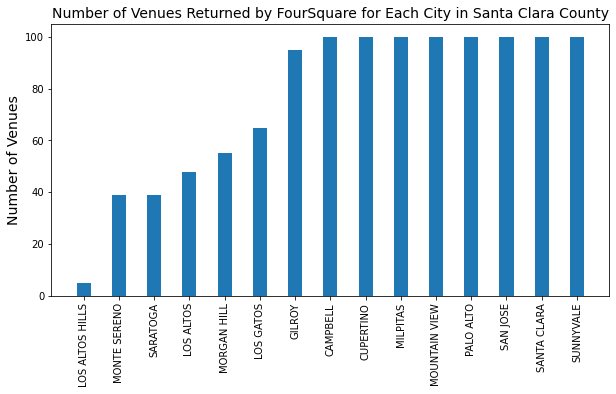

In [155]:
#matplotlib.rcParams.update({'font.size': 22})
df_number = county_venues.groupby('City').count()
df_number = df_number.reset_index()[['City','Venue']].rename(columns={'Venue':'Number of Venues'}).sort_values(by=['Number of Venues'])

plt.figure(figsize = (10,5))
plt.bar(df_number['City'].to_list(), df_number['Number of Venues'].to_list(), width = 0.4)
plt.ylabel('Number of Venues', fontsize = 14)
plt.xticks(rotation ='vertical')
plt.title('Number of Venues Returned by FourSquare for Each City in Santa Clara County',fontsize=14)
from matplotlib import pyplot as plt
plt.savefig('number_of_venues_per_cluster.png')

In [101]:
df_number.sort_values(by=['Number of Venues'])

,City,Number of Venues
4,LOS ALTOS HILLS,5
7,MONTE SERENO,39
13,SARATOGA,39
3,LOS ALTOS,48
8,MORGAN HILL,55
5,LOS GATOS,65
2,GILROY,95
0,CAMPBELL,100
1,CUPERTINO,100
6,MILPITAS,100


In [43]:
print('There are {} uniques categories.'.format(len(county_venues['Venue Category'].unique())))

There are 220 uniques categories.


## Analyzing cities in Santa Clara County.

In [102]:
# one hot encoding
county_onehot = pd.get_dummies(county_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
county_onehot['City'] = county_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [county_onehot.columns[-1]] + list(county_onehot.columns[:-1])
county_onehot = county_onehot[fixed_columns]

county_onehot.head()

,City,ATM,Afghan Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,College Track,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Event,Other Repair Shop,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Soccer Field,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Travel Agency,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,MILPITAS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,MILPITAS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,MILPITAS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

We can print the top five venue categories as well as their respective counts for each city in Santa Clara County as shown below.

In [183]:
county_grouped1 = county_onehot.groupby('City').sum().reset_index()

num_top_venues = 5

for city in county_grouped1['City']:
    print("----"+city+"----")
    temp = county_grouped1[county_grouped1['City'] == city].T.reset_index()
    temp.columns = ['venue','count']
    temp = temp.iloc[1:]
    temp['count'] = temp['count'].astype(int)
    print(temp.sort_values('count', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CAMPBELL----
                venue  count
0  Mexican Restaurant      7
1         Pizza Place      6
2         Coffee Shop      5
3  Italian Restaurant      4
4      Sandwich Place      4


----CUPERTINO----
                 venue  count
0  Japanese Restaurant      6
1               Bakery      6
2          Coffee Shop      4
3   Chinese Restaurant      4
4   Mexican Restaurant      3


----GILROY----
                    venue  count
0      Mexican Restaurant      9
1  Furniture / Home Store      5
2    Fast Food Restaurant      4
3              Taco Place      3
4             Coffee Shop      3


----LOS ALTOS----
                 venue  count
0          Pizza Place      4
1  American Restaurant      3
2          Coffee Shop      3
3                 Park      3
4   Mexican Restaurant      3


----LOS ALTOS HILLS----
          venue  count
0          Park      2
1          Pool      1
2  Home Service      1
3  Soccer Field      1
4           ATM      0


----LOS GATOS----
          

Now, we repeat the process but this time we take a look at frequency (mean) number for the top five categories.

In [106]:
county_grouped = county_onehot.groupby('City').mean().reset_index()

In [53]:
county_grouped.shape

(15, 221)

In [107]:
num_top_venues = 5

for city in county_grouped['City']:
    print("----"+city+"----")
    temp = county_grouped[county_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CAMPBELL----
                venue  freq
0  Mexican Restaurant  0.07
1         Pizza Place  0.06
2         Coffee Shop  0.05
3  Italian Restaurant  0.04
4      Sandwich Place  0.04


----CUPERTINO----
                 venue  freq
0  Japanese Restaurant  0.06
1               Bakery  0.06
2          Coffee Shop  0.04
3   Chinese Restaurant  0.04
4   Mexican Restaurant  0.03


----GILROY----
                    venue  freq
0      Mexican Restaurant  0.09
1  Furniture / Home Store  0.05
2    Fast Food Restaurant  0.04
3              Taco Place  0.03
4             Coffee Shop  0.03


----LOS ALTOS----
                 venue  freq
0          Pizza Place  0.08
1  American Restaurant  0.06
2          Coffee Shop  0.06
3                 Park  0.06
4   Mexican Restaurant  0.06


----LOS ALTOS HILLS----
          venue  freq
0          Park   0.4
1          Pool   0.2
2  Home Service   0.2
3  Soccer Field   0.2
4           ATM   0.0


----LOS GATOS----
                     venue  freq
0      

Let's define a function to sort venues in a descending order.

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We check the top 5 common venues for each city.

In [7]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = county_grouped['City']

for ind in np.arange(county_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(county_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted

In [4]:
from matplotlib.ticker import StrMethodFormatter
df1 = county_grouped.drop('City', 1)
range_n_clusters = [2, 3, 4, 5, 6]
elbow = []
ss = []
for n_clusters in range_n_clusters:
   #iterating through cluster sizes
    clusterer = KMeans(n_clusters = n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(df1.values)
   #Finding the average SSE"
    elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared errors')
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared errors (SSE)")
plt.title('The Elbow Method for Finding the Optimal K', fontsize = 14 )
plt.xticks ([2, 3, 4, 5, 6])

plt.show()

In [110]:
# set number of clusters
kclusters = 4

sc_county_grouped_clustering = county_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sc_county_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 2, 1, 2, 0, 2, 2, 0])

We create a new dataframe that includes clusters as well as the top 5 venue categories for each city in Santa Clara County.

In [5]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

county_merged = county_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
county_merged = county_merged.join(cities_venues_sorted.set_index('City'), on='City')

Let's visualize the clusters on the map.

In [157]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = 2*[i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(county_merged['Latitude'], county_merged['Longitude'], county_merged['City'], county_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

Now, we need to find appropriate labels for our clusters. To do that, we create a bar plot showing the 1st most common venue categories in each cluster. 

In [6]:
df_merged = pd.merge(county_merged, MC_venue, on='City')
df_merged = df_merged[['City','Cluster Labels','1st Most Common Venue_x','Count']] 
df_merged.rename(columns={'1st Most Common Venue_x':'1st Most Common Venue','Cluster Labels':'Cluster'},inplace=True)
df_merged

In [117]:
df_cluster = df_merged.drop(['City'], axis=1) 
df_cluster = df_cluster[['Cluster','Count', '1st Most Common Venue']].set_index('Cluster')
df_cluster = df_cluster.sort_index()
df_cluster

,Count,1st Most Common Venue
Cluster,,
0,6,Chinese Restaurant
0,9,Mexican Restaurant
0,7,Mexican Restaurant
0,6,Japanese Restaurant
0,6,Coffee Shop
0,9,Mexican Restaurant
0,4,Asian Restaurant
0,7,Coffee Shop
0,6,Ice Cream Shop


In [159]:
county_merged.head()

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,MILPITAS,37.428272,-121.906624,0,Chinese Restaurant,Indian Restaurant,Korean Restaurant,Mexican Restaurant,Sandwich Place
1,GILROY,37.006508,-121.563172,0,Mexican Restaurant,Furniture / Home Store,Fast Food Restaurant,Coffee Shop,Sandwich Place
2,MORGAN HILL,37.130408,-121.654497,2,Italian Restaurant,Pizza Place,Brewery,Vietnamese Restaurant,Convenience Store
3,MONTE SERENO,37.236333,-121.992458,2,Pizza Place,Mexican Restaurant,Restaurant,Pet Store,Bakery
4,SARATOGA,37.263832,-122.023015,3,American Restaurant,Italian Restaurant\t,Coffee Shop,Burger Joint,Café


In [175]:
cities_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,CAMPBELL,Mexican Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Sandwich Place
1,CUPERTINO,Japanese Restaurant,Bakery,Coffee Shop,Chinese Restaurant,Park
2,GILROY,Mexican Restaurant,Furniture / Home Store,Fast Food Restaurant,Coffee Shop,Sandwich Place
3,LOS ALTOS,Pizza Place,American Restaurant,Park,Mexican Restaurant,Coffee Shop
4,LOS ALTOS HILLS,Park,Pool,Home Service,Soccer Field,Yoga Studio
5,LOS GATOS,Pizza Place,New American Restaurant,Café,Mexican Restaurant,Coffee Shop
6,MILPITAS,Chinese Restaurant,Indian Restaurant,Korean Restaurant,Mexican Restaurant,Sandwich Place
7,MONTE SERENO,Pizza Place,Mexican Restaurant,Restaurant,Pet Store,Bakery
8,MORGAN HILL,Italian Restaurant,Pizza Place,Brewery,Vietnamese Restaurant,Convenience Store
9,MOUNTAIN VIEW,Coffee Shop,Park,Pizza Place,Mexican Restaurant,Yoga Studio


In [176]:
cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,CAMPBELL,Mexican Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Sandwich Place
1,CUPERTINO,Japanese Restaurant,Bakery,Coffee Shop,Chinese Restaurant,Park
2,GILROY,Mexican Restaurant,Furniture / Home Store,Fast Food Restaurant,Coffee Shop,Sandwich Place
3,LOS ALTOS,Pizza Place,American Restaurant,Park,Mexican Restaurant,Coffee Shop
4,LOS ALTOS HILLS,Park,Pool,Home Service,Soccer Field,Yoga Studio


In [134]:
df_cluster['1st Most Common Venue'].unique()

array(['Chinese Restaurant', 'Mexican Restaurant', 'Japanese Restaurant',
       'Coffee Shop', 'Asian Restaurant', 'Ice Cream Shop',
       'Home Service', 'Italian Restaurant', 'Pizza Place',
       'American Restaurant'], dtype=object)

In [137]:
midxxx = pd.MultiIndex(levels=[['0', '1', '2', '3'],
                             ['Chinese Restaurant', 'Mexican Restaurant', 'Japanese Restaurant',
       'Coffee Shop', 'Asian Restaurant', 'Ice Cream Shop', 'Home Service',
       'Italian Restaurant', 'Pizza Place', 'American Restaurant']],
                      codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
df_final = pd.DataFrame(index=midxxx, columns=['Number of Venues'],
                   data=[[6],[25],[6],[13],[4],[6],[0],[0],[0],[0],
                        [0],[0],[0],[0],[0],[0],[2],[0],[0],[0],
                        [0],[0],[0],[0],[0],[0],[0],[4],[10],[0],
                        [0],[0],[0],[0],[0],[0],[0],[0],[0],[3]])
df_final

Number of Venues
0 Chinese Restaurant                  6
  Mexican Restaurant                 25
  Japanese Restaurant                 6
  Coffee Shop                        13
  Asian Restaurant                    4
  Ice Cream Shop                      6
  Home Service                        0
  Italian Restaurant                  0
  Pizza Place                         0
  American Restaurant                 0
1 Chinese Restaurant                  0
  Mexican Restaurant                  0
  Japanese Restaurant                 0
  Coffee Shop                         0
  Asian Restaurant                    0
  Ice Cream Shop                      0
  Home Service                        2
  Italian Restaurant                  0
  Pizza Place                         0
  American Restaurant                 0
2 Chinese Restaurant                  0
  Mexican Restaurant                  0
  Japanese Restaurant                 0
  Coffee Shop                         0
  Asian Restaurant                    0
  Ice Cream Shop                      0
  Home Service                        0
  Italian Restaurant                  4
  Pizza Place                        10
  American Restaurant                 0
3 Chinese Restaurant                  0
  Mexican Restaurant                  0
  Japanese Restaurant                 0
  Coffee Shop                         0
  Asian Restaurant                    0
  Ice Cream Shop                      0
  Home Service                        0
  Italian Restaurant                  0
  Pizza Place                         0
  American Restaurant                 3

#### Finally, we have our bar plot showing the 1st most common venue categories in each cluster.

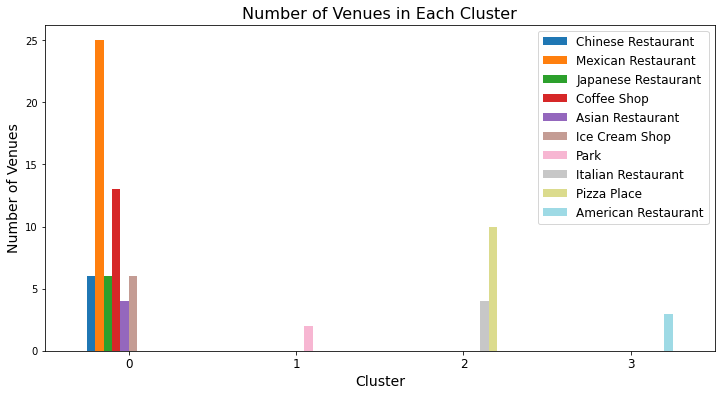

In [174]:
labels = ['Chinese Restaurant', 'Mexican Restaurant', 'Japanese Restaurant',
       'Coffee Shop', 'Asian Restaurant', 'Ice Cream Shop', 'Park',
       'Italian Restaurant', 'Pizza Place', 'American Restaurant']
clr = ('blue', 'forestgreen', 'gold', 'red', 'purple','grey', 'pink', 'brown', 'orange', 'black')
fig3, ax3 = plt.subplots(nrows=1, figsize=(12, 6))

df_final.unstack().plot(kind='bar', legend=False, cmap=plt.cm.get_cmap('tab20', 10), ax=ax3)

plt.title('Number of Venues in Each Cluster', fontsize=16)
plt.xlabel('Cluster',fontsize=14)
plt.ylabel('Number of Venues',fontsize=14)

plt.xticks(rotation=0, fontsize=12)
   

plt.legend(labels,loc='best',fontsize=12)
plt.show()

#### Now, we can explore cities in each cluster. Note that there is only one city in cluster 1 and also one city in cluster 3.

In [177]:
county_merged

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,MILPITAS,37.428272,-121.906624,0,Chinese Restaurant,Indian Restaurant,Korean Restaurant,Mexican Restaurant,Sandwich Place
1,GILROY,37.006508,-121.563172,0,Mexican Restaurant,Furniture / Home Store,Fast Food Restaurant,Coffee Shop,Sandwich Place
2,MORGAN HILL,37.130408,-121.654497,2,Italian Restaurant,Pizza Place,Brewery,Vietnamese Restaurant,Convenience Store
3,MONTE SERENO,37.236333,-121.992458,2,Pizza Place,Mexican Restaurant,Restaurant,Pet Store,Bakery
4,SARATOGA,37.263832,-122.023015,3,American Restaurant,Italian Restaurant\t,Coffee Shop,Burger Joint,Café
5,CAMPBELL,37.287063,-121.944882,0,Mexican Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Sandwich Place
6,CUPERTINO,37.322893,-122.032290,0,Japanese Restaurant,Bakery,Coffee Shop,Chinese Restaurant,Park
7,MOUNTAIN VIEW,37.389389,-122.083210,0,Coffee Shop,Park,Pizza Place,Mexican Restaurant,Yoga Studio
8,SAN JOSE,37.336191,-121.890583,0,Mexican Restaurant,Coffee Shop,Art Gallery,Cocktail Bar,Pub
9,LOS ALTOS HILLS,37.379663,-122.137464,1,Home Service,Pool,Park,Soccer Field,Yoga Studio


#### Cities in Cluster 0 --- Intensive Asian and Mexican restaurants

In [165]:
county_merged[county_merged['Cluster Labels'] == 0].reset_index()

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,MILPITAS,37.428272,-121.906624,0,Chinese Restaurant,Indian Restaurant,Korean Restaurant,Mexican Restaurant,Sandwich Place
1,GILROY,37.006508,-121.563172,0,Mexican Restaurant,Furniture / Home Store,Fast Food Restaurant,Coffee Shop,Sandwich Place
2,CAMPBELL,37.287063,-121.944882,0,Mexican Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Sandwich Place
3,CUPERTINO,37.322893,-122.032290,0,Japanese Restaurant,Bakery,Coffee Shop,Chinese Restaurant,Park
4,MOUNTAIN VIEW,37.389389,-122.083210,0,Coffee Shop,Park,Pizza Place,Mexican Restaurant,Yoga Studio
5,SAN JOSE,37.336191,-121.890583,0,Mexican Restaurant,Coffee Shop,Art Gallery,Cocktail Bar,Pub
6,SANTA CLARA,37.354113,-121.955174,0,Asian Restaurant,Korean Restaurant,Thai Restaurant,Bank,Indian Restaurant
7,SUNNYVALE,37.368830,-122.036350,0,Coffee Shop,Indian Restaurant,Mexican Restaurant,Chinese Restaurant,Sandwich Place
8,PALO ALTO,37.444329,-122.159847,0,Ice Cream Shop,New American Restaurant,Café,Japanese Restaurant,Coffee Shop


#### Cities in Cluster 2 --- Pizza and Italian restaurants

In [169]:
county_merged[county_merged['Cluster Labels'] == 2].reset_index(drop=True)

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,MORGAN HILL,37.130408,-121.654497,2,Italian Restaurant,Pizza Place,Brewery,Vietnamese Restaurant,Convenience Store
1,MONTE SERENO,37.236333,-121.992458,2,Pizza Place,Mexican Restaurant,Restaurant,Pet Store,Bakery
2,LOS ALTOS,37.379063,-122.116578,2,Pizza Place,American Restaurant,Park,Mexican Restaurant,Coffee Shop
3,LOS GATOS,37.226611,-121.974680,2,Pizza Place,New American Restaurant,Café,Mexican Restaurant,Coffee Shop


## <font color='blue'>End of Part 1.</font>